Diamonds prediction

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


read data

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/Nehaal-Patel/Machine-Learning-Regression-Models/master/Diamond_Price/diamonds.csv")
data=data.drop(data.columns[0],axis=1)


The first column contains an index column, so we should remove it.


Data Overview

In [44]:
print(data.shape)
print(data.info())
print(data.describe())

(53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  int64  
 2   color    53940 non-null  int64  
 3   clarity  53940 non-null  int64  
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 4.1 MB
None
              carat           cut  ...             y             z
count  53940.000000  53940.000000  ...  53940.000000  53940.000000
mean       0.797940      3.904097  ...      5.734526      3.538734
std        0.474011      1.116600  ...      1.142135      0.705699
min        0.200000      1.000000  ...      0.000000      0.000000
25%        0.400000      3.000000

Shape: The dataset contains 53,940 rows and 11 columns, which shows a moderately large dataset.
info : there aren't any missing values

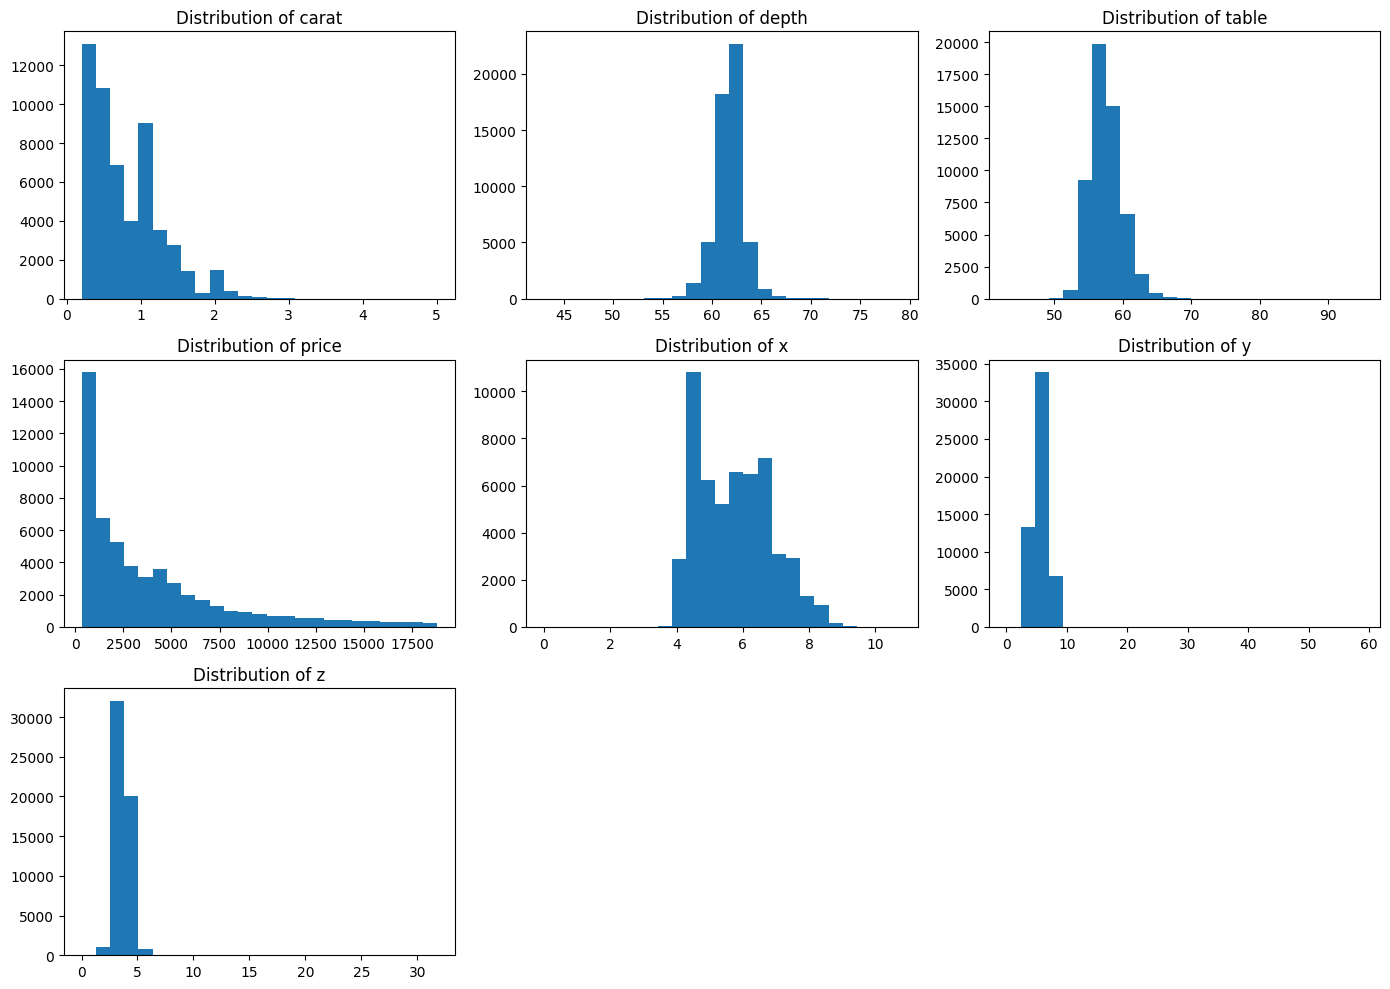

In [5]:
numeric_columns=data.select_dtypes(include="number").columns
plt.figure(figsize=(14,10))
num_cols = data.select_dtypes("number").shape[1]
n_rows = int(np.ceil(num_cols/3))
for index, column in enumerate(numeric_columns):
    plt.subplot(n_rows,3,index+1)
    plt.hist(data[column], bins=25)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

features like carat and price tend to show right-skewness, indicating that there are many diamonds with lower values and a few with high values.
The x, y, and z data look mostly balanced (normal), but there are extreme values

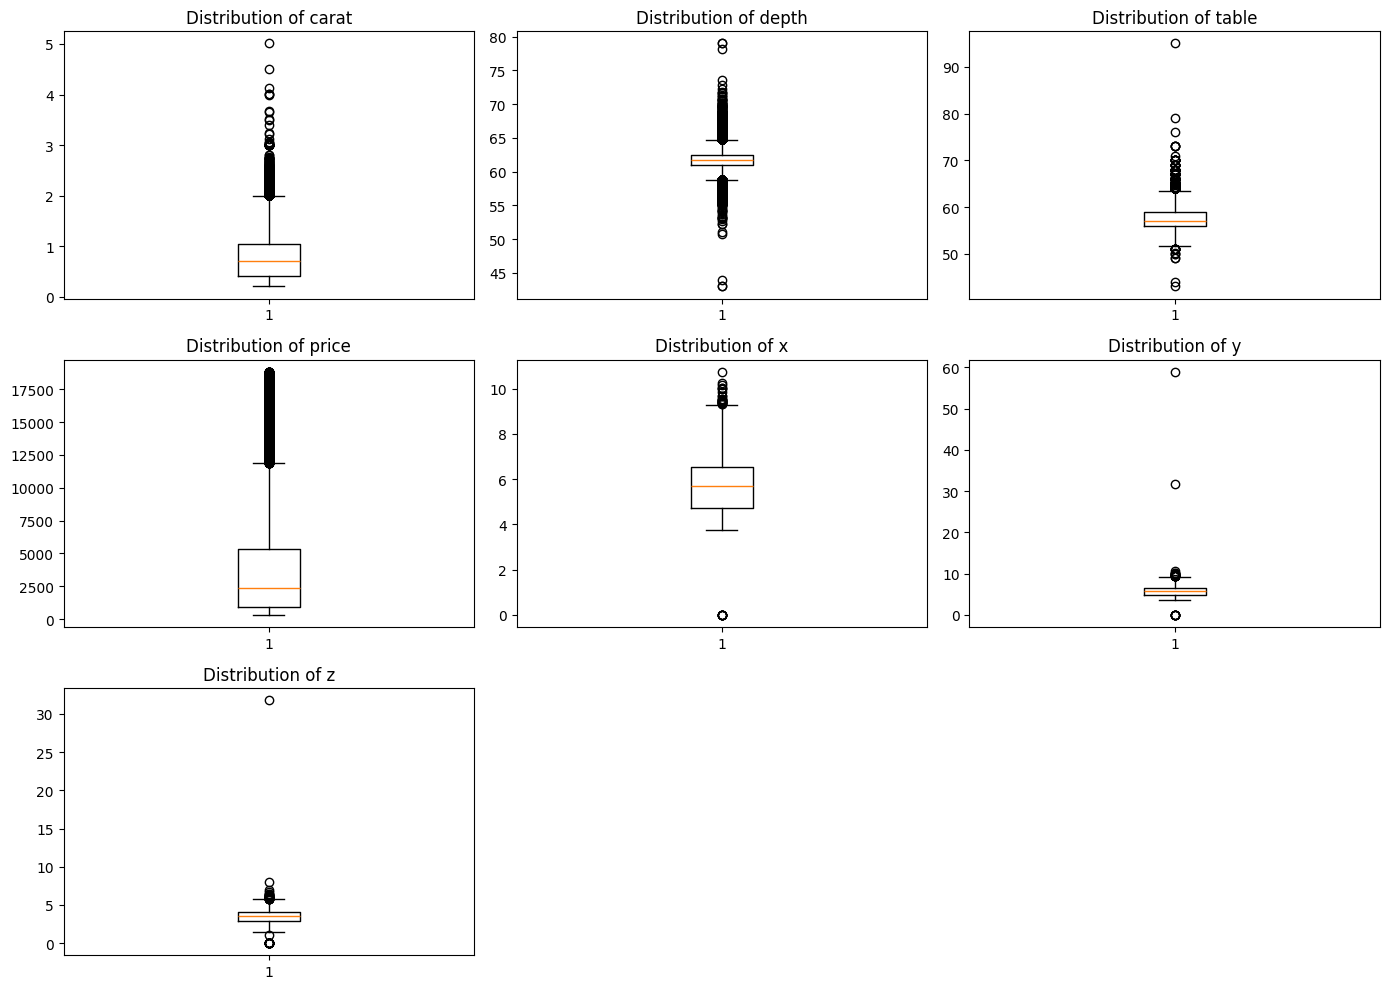

In [6]:
plt.figure(figsize=(14,10))
n_rows = int(np.ceil(num_cols/3))
for index , column in enumerate(numeric_columns):
    plt.subplot(n_rows,3,index+1)
    plt.boxplot(data[column])
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

We can see that there are many outliers.


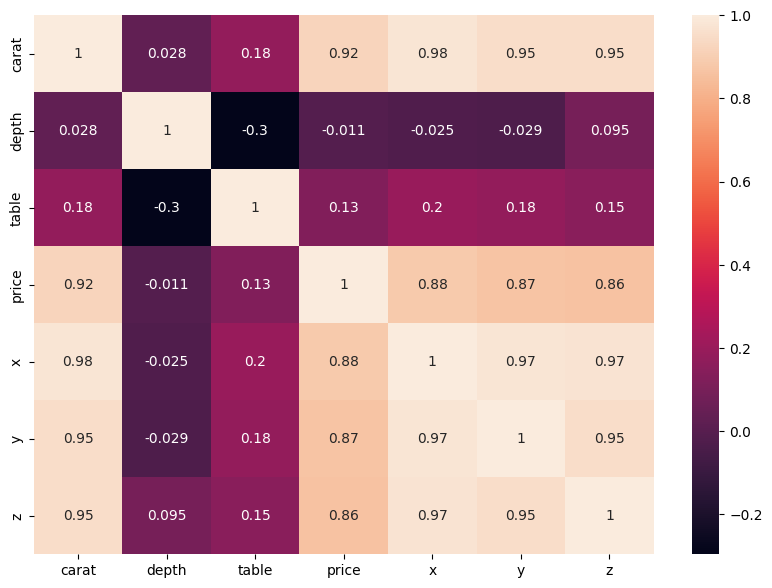

In [7]:
plt.figure(figsize=(10,7))
sns.heatmap(data.select_dtypes(include="number").corr(),annot=True)
plt.show()

There is a high correlation between carat, x, y, z, and price.


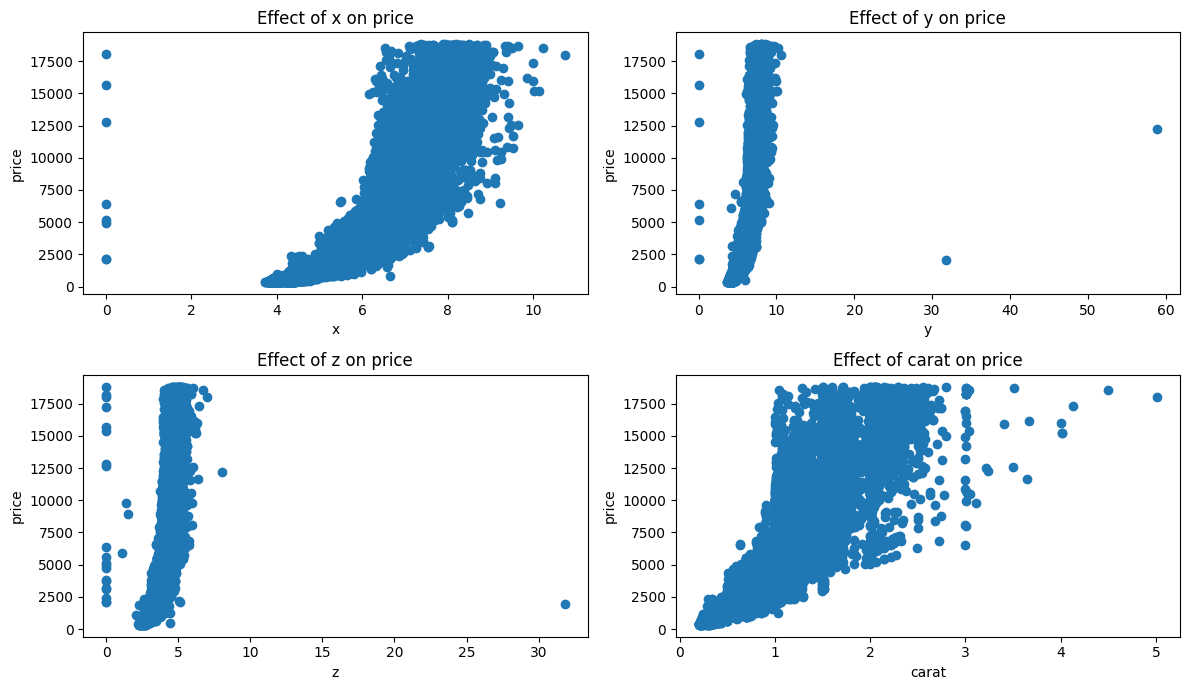

In [45]:
scatter_graph=["x","y","z","carat"]
nrows_of_scatter = int(np.ceil(len(scatter_graph)/3))

plt.figure(figsize=(12,7))
for index , column in enumerate(scatter_graph) :
    plt.subplot(nrows_of_scatter,2,index+1)
    plt.scatter(data[column],data['price'])
    plt.title(f"Effect of {column} on price")
    plt.xlabel(column)
    plt.ylabel("price")
plt.tight_layout()
plt.show()




The scatter plots for x, y, and z against price show that when one of them increases, the price generally increases as well. However, the relationship might not be strictly linear.

The scatter plot for carat shows a strong positive relationship with price. As the carat weight increases, the price tends to increase dramatically. This is expected because carat is a key determinant in valuation for diamonds.

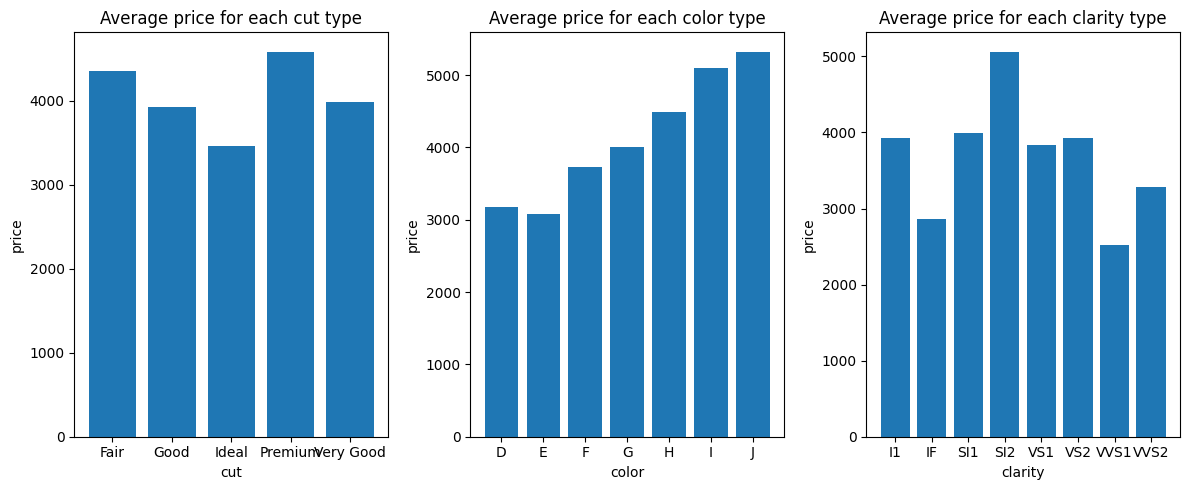

In [9]:
bar_graph=["cut","color","clarity"]
nrows_of_bar = int(np.ceil(len(bar_graph)/3))
plt.figure(figsize=(12,5))
for index , column in enumerate(bar_graph) :
    mean_of_category=data.groupby(column)["price"].mean()
    plt.subplot(nrows_of_bar,3,index+1)
    plt.bar(mean_of_category.index,mean_of_category.values)
    plt.title(f"Average price for each {column} type")
    plt.xlabel(column)
    plt.ylabel("price")
plt.tight_layout()
plt.show()

The bar graphs underscore the impact of categorical variables: the diamond's cut, color, and clarity all systematically affect its average price. The observed differences among categories could be used to further prioritize which of these quality factors have the most market impact.

In [10]:
cut_mapping = {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
color_mapping = {'J':1, 'I':2, 'H':3, 'G':4, 'F':5, 'E':6, 'D':7}
clarity_mapping = {'I1':1, 'SI2':2, 'SI1':3, 'VS2':4, 'VS1':5, 'VVS2':6, 'VVS1':7, 'IF':8}
data['cut']=data['cut'].map(cut_mapping)
data['color'] = data['color'].map(color_mapping)
data['clarity'] = data['clarity'].map(clarity_mapping)

Because the model we will use only accepts numerical columns, we converted the categorical columns to numeric.
I used mapping to convert the categorical values in the 'cut', 'color', and 'clarity' columns into numerical values, because each category has a different level of quality that affects the diamond's value. This transformation preserves the natural order of the categories, which is important for analysis and modeling.

In [11]:
def log_data(df , array_of_column=None):
    if isinstance(df,pd.Series):
        return np.log1p(df)
    elif isinstance(df,pd.DataFrame):
        for col in array_of_column:        
            df[col]=np.log1p(df[col])
        return df
    else :
        raise TypeError("Input must be a pandas DataFrame or Series.")

features=data.drop("price",axis=1)
target=data['price']
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.3,random_state=42)
cols_to_log = ["carat", "x", "y", "z"]
X_train = log_data(X_train, cols_to_log)
X_test = log_data(X_test, cols_to_log)
y_train = log_data(y_train)
y_test = log_data(y_test)
best_max_depth=None
best_min_samples_leaf=2
best_min_samples_split=5
dt=RandomForestRegressor(random_state=42,max_depth=best_max_depth,min_samples_leaf=best_min_samples_leaf,min_samples_split=best_min_samples_split)
dt.fit(X_train,y_train)


RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, random_state=42)

log1p helps reduce the impact of outliers.

In [12]:
y_pred_train=dt.predict(X_train)
y_pred_test=dt.predict(X_test)
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)
y_pred_train = np.expm1(y_pred_train)
y_pred_test = np.expm1(y_pred_test)
print("RMSE of train using random forest model:", mean_squared_error(y_train_original, y_pred_train) ** 0.5)
print("R2 score of train using random forest model :", r2_score(y_train_original, y_pred_train))
print("RMSE of test using random forest model :", mean_squared_error(y_test_original, y_pred_test) ** 0.5)
print("R2 score of test using random forest model :", r2_score(y_test_original, y_pred_test))

RMSE of train: 307.78667342429964
R2 score of train: 0.9940980384332126
RMSE of test: 540.6493628935534
R2 score of test: 0.9812578596841035


To check for underfitting or overfitting, we should compare the difference between the training and test errors.

Because we used the logarithm in a previous step, we should apply the exponential to get a correct comparison.

In [37]:
comparison_df = pd.DataFrame({
    'Actual (y_test)': y_test_original[:10].values,
    'Predicted (y_pred)': y_pred_test[:10]
})

# Print the comparison DataFrame
print(comparison_df)

   Actual (y_test)  Predicted (y_pred)
0            559.0          603.259398
1           2201.0         2181.520525
2           1238.0         1356.407017
3           1304.0         1487.882867
4           6901.0        11348.359188
5           3011.0         3863.359772
6           1765.0         1668.606183
7           1679.0         1790.115363
8           2102.0         2209.368791
9           4789.0         5176.171507


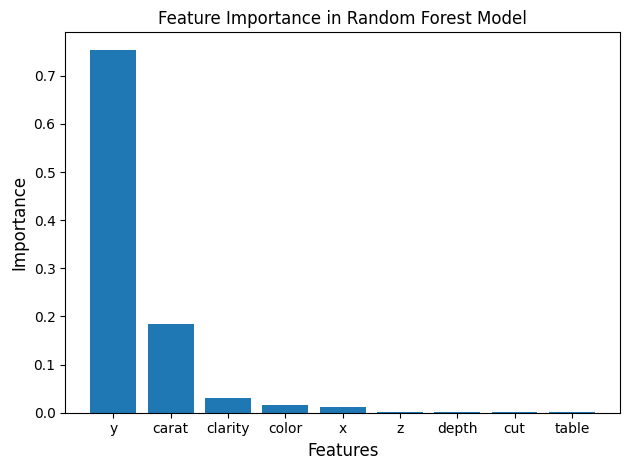

In [14]:
importance_of_features = pd.DataFrame({"Feature":features.columns,"Importance":dt.feature_importances_})
importance_of_features = importance_of_features.sort_values("Importance",ascending=False)
plt.bar(importance_of_features["Feature"],importance_of_features["Importance"])
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Features",fontsize=12)
plt.ylabel("Importance",fontsize=12)
plt.tight_layout()
plt.show()

In [40]:
standard_scaler_columns = X_train.select_dtypes(include="number").columns
preprocessor = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_scaler_columns), 
        ],remainder='passthrough')

model_pipeline=Pipeline(steps=[('preprocessor',preprocessor),
                        ('regressor',LinearRegression())])
model_pipeline.fit(X_train,y_train)

y_pred_train=model_pipeline.predict(X_train)
y_pred_test=model_pipeline.predict(X_test)
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)
y_pred_train = np.expm1(y_pred_train)
y_pred_test = np.expm1(y_pred_test)

print("RMSE of train using linear regression model:", mean_squared_error(y_train_original, y_pred_train) ** 0.5)
print("R2 score of train using linear regression model :", r2_score(y_train_original, y_pred_train))
print("RMSE of test using linear regression model :", mean_squared_error(y_test_original, y_pred_test) ** 0.5)
print("R2 score of test using linear regression model :", r2_score(y_test_original, y_pred_test))

RMSE of train using linear regression model: 2309.9693994328986
R2 score of train using linear regression model : 0.6675631128615774
RMSE of test using linear regression model : 1705.3716891555869
R2 score of test using linear regression model : 0.81352273459397


 We use StandardScaler before Linear Regression to ensure that all features contribute equally to the model, preventing bigger numbers from unfairly influencing the result.

After applying the Random Forest and Linear Regression models, we can see that Random Forest performs better than Linear Regression.